# Problem Satatement
The goal of this project is to understand different types of mall customers by grouping them based on how much they earn and how they spend, helping marketing teams design campaigns that truly match customer behavior.

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imporet Libraries and load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Mall_Customers.csv')

## Pre Inspection

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df.isnull().sum().sum()

np.int64(0)

In [7]:
df.duplicated().sum()

np.int64(0)

## Data Cleaning

In [8]:
# Replace ' ' with '_' from variables
df.columns = df.columns.str.replace(' ','_').str.strip()

In [9]:
# Rename Column Name
df.rename(columns = {'Annual_Income_(k$)': 'Annual_Income'}, inplace = True)
df.rename(columns = {'Spending_Score_(1-100)':'Spending_Score'},inplace = True)

In [10]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual_Income', 'Spending_Score'], dtype='object')

## Data Understanding
- CustomerID: Identifier
- Gender: Helps compare buying behavior of males vs females
- Age: Helps find age-based groups (young, middle-aged, senior)
- Annual_Income: Shows customers purchasing power
- Spending_Score: Shows how much a customer actually spends

# Exploratery Data Analysis (EDA)

Understand behaviour and relationship between variables

### Age Distribusion

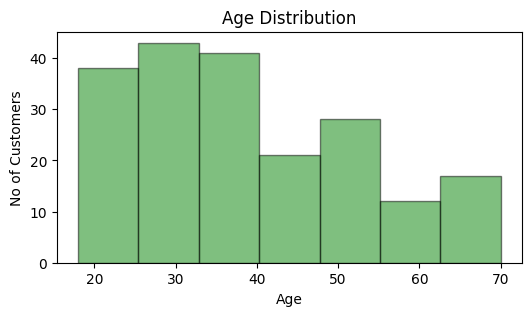

In [11]:
plt.figure(figsize = (6,3))
plt.hist(df['Age'],bins = 7,edgecolor = 'black',color = 'green',alpha = .5)
plt.xlabel('Age')
plt.ylabel('No of Customers')
plt.title('Age Distribution')
plt.show()

The age distribution chart shows that most mall customers are between 20 and 40 years old, indicating a younger customer base.

### Income vs Spending

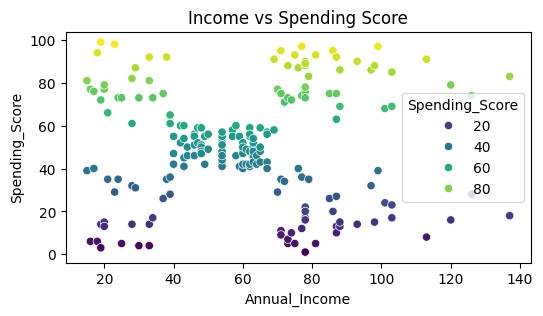

In [12]:
plt.figure(figsize = (6,3))
sns.scatterplot(
    data = df,
    x = 'Annual_Income',
    y = 'Spending_Score',
    hue = 'Spending_Score',
    palette = 'viridis'
)
plt.title('Income vs Spending Score')
plt.show()

The chart shows that customer spending does not depend only on income, and distinct customer segments are clearly visible.

### Gender-based spending

Text(0.5, 1.0, 'Gender based spending pattern')

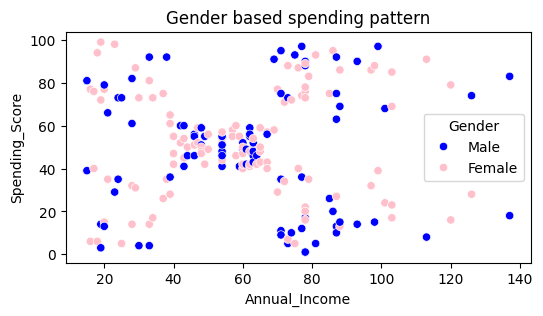

In [13]:
plt.figure(figsize = (6,3))
sns.scatterplot(data = df,
                x = 'Annual_Income',
                y = 'Spending_Score',
                hue = 'Gender',
                palette = {'Male':'blue','Female':'pink'}
                )

plt.title('Gender based spending pattern')

The chart shows that female customers generally have higher spending scores than male customers, while spending varies for both genders across income levels

### Spending Score Distribution by Gender

/tmp/ipython-input-4118511468.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


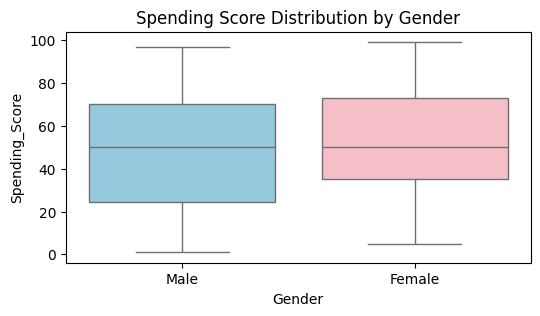

In [14]:
plt.figure(figsize = (6,3))
sns.boxplot(
    data = df,
    x = 'Gender',
    y = 'Spending_Score',
    palette = ['skyblue','lightpink']
)

plt.title('Spending Score Distribution by Gender')
plt.show()

The boxplot shows that females generally have a slightly higher and more consistent spending score than males.

### Gender based Spending Score (Bar Chart)

/tmp/ipython-input-3840085979.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df,


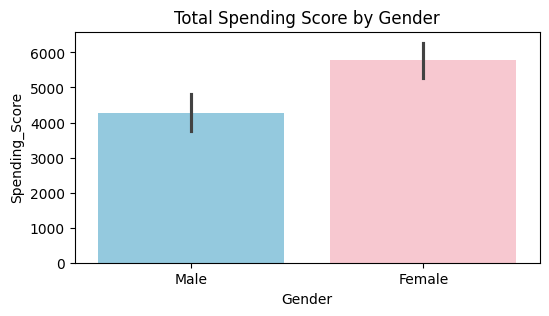

In [15]:
plt.figure(figsize = (6,3))
sns.barplot(data = df,
            x = 'Gender',
            y = 'Spending_Score',
            estimator = 'sum',
            palette = {'Male':'skyblue','Female': 'pink'}
            )
plt.title('Total Spending Score by Gender')
plt.show()

this bar chart shows spending is slightly higher for Female in comparision of Male

## Feature Scaling
Feature scaling is required in clustering because most clustering algorithms use distance to group data points. If features are on different scales, the feature with larger values dominates the distance calculation and gives misleading clusters.

In [16]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(
    df[['Annual_Income','Spending_Score']]
)

We used standard Scaler to scale both input feature on same scale


### 6 - Select Optimal Number of clusters
Selecting the optimal number of clusters is necessary because it directly affects how well the data is segmented. Too few clusters hide important patterns, while too many clusters create unnecessary complexity. The optimal number ensures that clusters are compact, well-separated, and meaningful for business decision-making

### 6.1 Elbow method to find optimal number of clusters

In [17]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
  kmeans =KMeans(n_clusters = k,random_state = 42)
  kmeans.fit(x_scaled)
  wcss.append(kmeans.inertia_)

print('Number of clusters:',wcss)

Number of clusters: [399.99999999999994, 273.66888662642003, 157.70400815035939, 109.22822707921345, 65.56840815571681, 60.132874871934206, 49.668244837367965, 37.31912287833882, 32.495081199100916, 30.05932269404222]


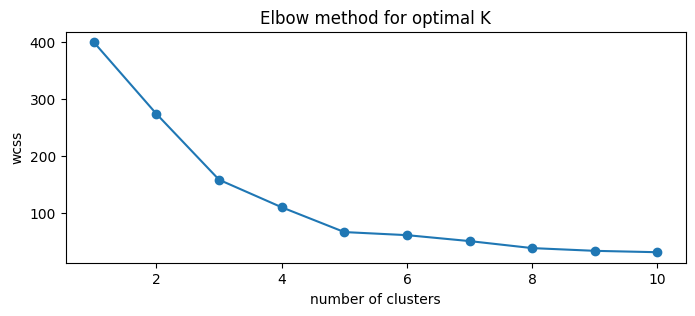

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,3))
plt.plot(
    range(1,11),
    wcss,
    marker = 'o'
)
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.title('Elbow method for optimal K')
plt.show()

### 6.2 Silhouette Score (Final Decision)

In [19]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x_scaled)

    score = silhouette_score(x_scaled, labels)
    silhouette_scores.append(score)


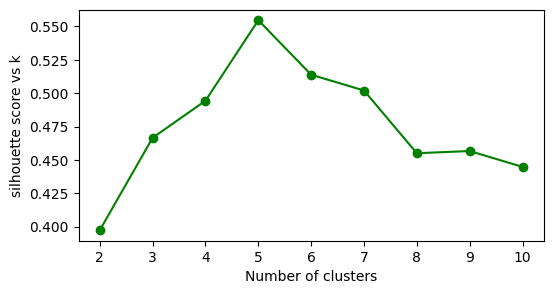

In [20]:
plt.figure(figsize = (6,3))
plt.plot(range(2,11),silhouette_scores,marker = 'o',color = 'green')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score vs k')
plt.show()

“The optimal number of clusters is the value of K where clusters are well-separated and internally compact, and increasing K further does not significantly improve clustering quality. In my project, both the Elbow Method and Silhouette Score indicated that 5 is the optimal number of clusters.

### Train Model

In [21]:
kmeans =KMeans(n_clusters = 5,random_state = 42)
df['cluster'] = kmeans.fit_predict(x_scaled)

In [22]:
df['cluster'].value_counts().sort_index()

,count
cluster,
0,81
1,39
2,22
3,35
4,23


I verified that all clusters had sufficient data points.

### Income vs Spending

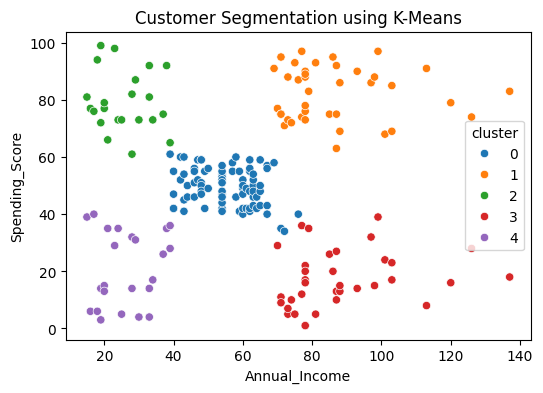

In [23]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df['Annual_Income'],
    y=df['Spending_Score'],
    hue=df['cluster'],
    palette='tab10'
)
plt.title("Customer Segmentation using K-Means")
plt.show()


The scatter plot visualizes customer segmentation using the K-Means algorithm based on Annual Income and Spending Score. Each point represents a customer, and different colors indicate distinct customer clusters identified by the model

### Find cluster centers

In [25]:
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['Annual_Income', 'Spending_Score']
)
centroids

,Annual_Income,Spending_Score
0,55.296296,49.518519
1,86.538462,82.128205
2,25.727273,79.363636
3,88.200000,17.114286
4,26.304348,20.913043


Cluster centers represent the average income and spending behavior of customers in each group. They help us clearly understand and label each customer segment, making it easier to create targeted and effective marketing strategies.

### Interpret clusters

In [26]:
df.groupby('cluster')[['Annual_Income','Spending_Score']].mean()

,Annual_Income,Spending_Score
cluster,,
0,55.296296,49.518519
1,86.538462,82.128205
2,25.727273,79.363636
3,88.200000,17.114286
4,26.304348,20.913043


- Cluster 0 (Medium Income, Medium Spending): Regular customers with balanced behavior; maintain engagement with standard offers.

- Cluster 1 (High Income, High Spending): Premium customers; target with loyalty programs and exclusive benefits.

- Cluster 2 (Low Income, High Spending): Price-sensitive but frequent shoppers; focus on discounts and promotions.

- Cluster 3 (High Income, Low Spending): Under-engaged customers with high potential; use upselling and personalized campaigns.

- Cluster 4 (Low Income, Low Spending): Low-value segment; minimal marketing investment.

### Business Insights & Recommendations

The analysis identified five distinct customer segments, allowing the business to tailor marketing strategies for each group. High-income high-spending customers can be retained through loyalty programs, while discount-driven customers can be targeted with promotional campaigns. This targeted approach improves customer engagement and marketing efficiency.

This project demonstrates the effective use of unsupervised machine learning for customer segmentation. By identifying meaningful customer groups, the business can make data-driven decisions and improve overall customer management.